# TV norm test


In [8]:
%pylab inline
from dipy.viz import fvtk
from dipy.core.gradients import gradient_table
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [6]:

import utils.math_utils as mu
import nibabel as nib


def load_subject_medium(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_medium40g_12x12x12x40_'+subject+'_b'+str(bval)+'.nii.gz')
        bsize=min(len(bvalpos), img.shape[3])
        gtab = gradient_table(bvals=bvals[bvalpos[:bsize]], bvecs=bvecs[:,bvalpos[:bsize]])
    else:
        img = nib.load(folder+ 'data_medium40g_12x12x12x40_'+subject+'.nii.gz')
        bsize = img.shape[3]
        gtab = gradient_table(bvals=bvals[:bsize], bvecs=bvecs[:,:bsize])
    return img, gtab


def load_subject_small(index, numbers, bval=None, bvalpos=None ):
    subject = str(numbers[index])
    folder = './HCP/'+subject+'/'
    bvals = np.loadtxt(folder+ 'bvals_'+subject)
    bvecs = np.loadtxt(folder+'bvecs_'+subject)
    
    if bvalpos is not None:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'_b'+str(bval)+'.nii.gz')
        bsize=min(len(bvalpos), img.shape[3])
        gtab = gradient_table(bvals=bvals[bvalpos[:bsize]], bvecs=bvecs[:,bvalpos[:bsize]])
    else:
        img = nib.load(folder+ 'data_small_12x12x12x6_'+subject+'.nii.gz')
        bsize = img.shape[3]
        gtab = gradient_table(bvals=bvals[:bsize], bvecs=bvecs[:,:bsize])
    return img, gtab



def mm(A):
    return (A.min(), A.max())


Populating the interactive namespace from numpy and matplotlib


(12, 12, 12, 6) (12, 12, 12, 40) bvals= [1985.0, 3010.0, 995.0, 5.0, 1990.0, 1000.0, 2985.0, 1995.0, 1005.0, 2990.0, 2000.0, 2995.0, 2005.0, 3000.0, 3005.0, 990.0]


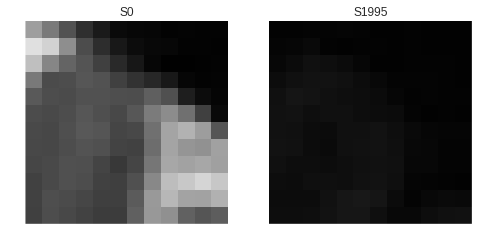

In [4]:
subjects = [100307, 100408, 180129, 180432, 180836, 180937]
bvals2000pos = [18, 27, 69, 75, 101, 107]
bvals5pos = [0,16,32,48,64,80,95,112,128,144,160,176,191,208,224,240,256,272]

# Esto es para quedame con la gtab que es igua a todos
img, gtab = load_subject_medium(0 , subjects)
img_s0, gtab_s0 = load_subject_small(0, subjects, bval=5, bvalpos=bvals5pos[0:6])

i_hr=img.get_data()
S0 = img_s0.get_data()

b=2
img_utils._isc(S0, i_hr, b=b, vmin=S0.min(),  vmax=S0.max(), titles=['S0', 'S'+str(int(gtab.bvals[b]))])
print S0.shape, i_hr.shape, 'bvals=',list(set(gtab.bvals))

# Cargando a Lena

(20, 20)


(20, 20, 20, 6)

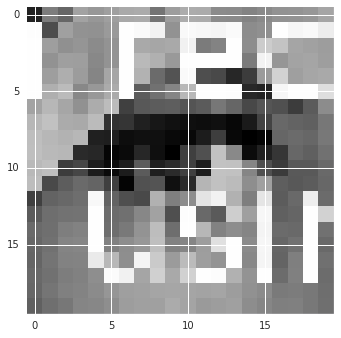

In [130]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

# Load the images.
corrupted_lena = Image.open("img/lena512_corrupted.png", mode='r')
lena = Image.open("img/lena512.png", mode='r')

 
Ucorr = np.array(corrupted_lena)
Ucorr = scipy.ndimage.zoom(Ucorr, 0.3, order=3)
Ucorr = Ucorr[70:-64, 70:-64]
print Ucorr.shape

Uorig = np.array(lena)
Uorig = scipy.ndimage.zoom(Uorig, 0.3, order=3)
Uorig = Uorig[70:-64, 70:-64]


#imshow(Ucorr, interpolation='none')

bval = 6
Nz = Ucorr.shape[0]
i_hr = np.zeros((Ucorr.shape[0],Ucorr.shape[1], Nz, bval))
i_uorig = np.zeros((Ucorr.shape[0],Ucorr.shape[1], Nz, bval))
for b in xrange(bval):
    for z in xrange(Nz):
        i_hr[:,:, z, b] = np.copy(Ucorr)
        i_uorig[:,:, z, b] = np.copy(Uorig)
        
        
# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
Known = np.zeros((Ucorr.shape[0],Ucorr.shape[1], Nz, bval))
for x in xrange(Ucorr.shape[0]):
    for y in xrange(Ucorr.shape[1]):
        for z in xrange(Nz):
            for b in xrange(bval):
                 if i_hr[x, y , z , b] == Uorig[x, y]:
                    Known[x, y , z , b] = 1        

        
#img_utils._is(i_hr)
#print i_hr.shape, 12*12*12*40, 74*74*18
#imshow(Ucorr, interpolation='none', cmap='gray')
imshow(i_hr[:,:,0,0], interpolation='none', cmap='gray')
i_hr.shape

## Def minimization problem

In [54]:
import cvxpy as cvx

def define_tvnorm_vars(Yhr, Nx, Ny, Nz, bval):
    # Hacer tiras de imagenes por cada b_val
    Yhr_b = cvx.reshape(Yhr, Nx*Ny*Nz, bval)
    slices_xy = []
    for b in xrange(bval):
        slices_xy_b = []
        #print Nx, Ny, Nz, bval
        pp = cvx.reshape(Yhr_b[:,b], Nx, Ny*Nz)
        for z in xrange(Nz):
            ppz = pp[:, z*Nz:(z+1)*Nz]
            #print ppz.size
            ppp = cvx.reshape(ppz, Nx, Ny)
            slices_xy_b.append(ppp)
        slices_xy.append(slices_xy_b)
    
    big_img = cvx.bmat(slices_xy)
    
    #muetsro la plancheta de imagenes
    bimg = np.asarray(big_img.value, dtype='float32').reshape((120, 400), order='F')
    imshow(bimg, interpolation='none', cmap='gray')

    
    print 'BMAT SIZE= ', big_img.size
    tv_norm = cvx.tv(big_img)

    return tv_norm, big_img

def define_opt_problem(i_hr):
    Nx, Ny, Nz, bval = i_hr.shape
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
      
    Yhr = cvx.Variable(vhrb, 1)    
    Yhr.value = np.copy(i_hr.reshape(-1, order='F'))

    tv_norm, big_img = define_tvnorm_vars(Yhr, Nx, Ny, Nz, bval)
    
    
    gamma = cvx.Parameter(sign="positive")
    gamma.value = 1
    
    #constraints = [Yhr >= 0, mu == cvx.sum_entries(Yhr)/vhrb, var == cvx.sum_squares(Yhr-mu)]
    constraints = [Yhr >= 0 ]
    
    
    Know_vect = Known.reshape(-1, order='F')
    i_uorig_vect = i_uorig.reshape(-1, order='F')
    constraints.append(cvx.mul_elemwise(Know_vect, Yhr) == cvx.mul_elemwise(Know_vect, i_uorig_vect))
    
    
    # Form objective.
    obj = cvx.Minimize(gamma*tv_norm)
    
    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    return prob, Yhr, tv_norm, big_img

# Run problem

BMAT SIZE=  (120, 400)
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 310725, CG tol ~ 1/iter^(2.00)
eps = 1.00e-10, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 95481, constraints m = 238443
Cones:	primal zero / dual free vars: 48000
	linear vars: 48000
	soc vars: 142443, soc blks: 47481
Setup time: 2.12e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.00e+01  2.33e+01  1.00e+00 -4.09e+07  1.06e+08  2.34e-08  8.03e-02 
   100| 5.56e-04  1.41e-03  8.26e-06  9.76e+05  9.76e+05  1.06e-09  2.16e+00 
   200| 9.34e-05  1.16e-04  5.01e-0

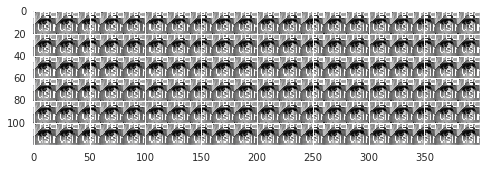

In [55]:
coef=22 # 4 --> 22, 6 --> 50
Nx, Ny, Nz, bval = i_hr.shape
vhr = Nx*Ny*Nz
vhrb = vhr*bval

prob, Yhr, tv_norm, big_img = define_opt_problem(i_hr )

# Solve problem
start_time = time.time()
res = prob.solve(solver='SCS', max_iters=2000, eps=1.00e-10, verbose=True)  # Returns the optimal value.
seg = time.time() - start_time
minutes = int(seg / 60)
print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
print "--- status:", prob.status, "optimal value", prob.value
print 


i_hr_recons = np.asarray(Yhr.value, dtype='float32').reshape((Nx, Ny, Nz, bval), order='F')
bimg = np.asarray(big_img.value, dtype='float32').reshape((120, 400), order='F')

print 'minimzation op_val =', prob.value

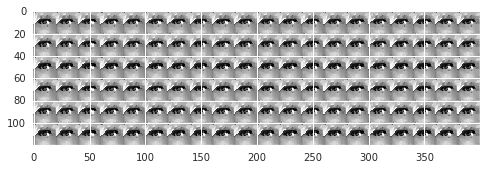

In [56]:

#imshow(i_hr_recons[:,:,0,0], interpolation='none', cmap='gray')
imshow(bimg, interpolation='none', cmap='gray')


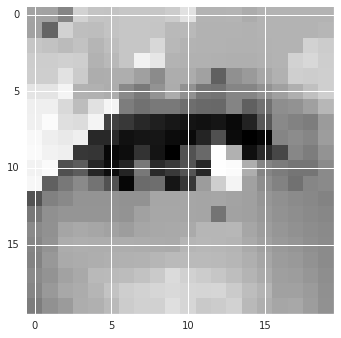

In [57]:
imshow(i_hr_recons[:,:,0,0], interpolation='none', cmap='gray')

# TV norm 3d

In [131]:

def define_opt_problem_tv3d(i_hr):
    Nx, Ny, Nz, bval = i_hr.shape
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
      
    Yhr = cvx.Variable(vhrb, 1)    
    Yhr.value = np.copy(i_hr.reshape(-1, order='F'))

    tv_list = []
    hasta = vhrb-bval*vhr
    print 'hasta', hasta,vhrb 
    for k in range(0, vhr):
        if k % Nx == 0 :
            continue
        x, y, z = k-1, k-Nx, k-Nx*Ny
        Yk = Yhr[k:vhrb:vhr]
        Yx , Yy, Yz = Yhr[x:vhrb:vhr], Yhr[y:vhrb:vhr] , Yhr[z:vhrb:vhr]
        
        #tv_list.append(cvx.sqrt(cvx.abs(Yk-Yx)**2+cvx.abs(Yk-Yy)**2+cvx.abs(Yk-Yz)**2))
        #tv_list.append(cvx.sqrt(cvx.abs(Yk-Yx)+cvx.abs(Yk-Yy)+cvx.abs(Yk-Yz)))
        tv_list.append(cvx.abs(Yk-Yx)+cvx.abs(Yk-Yy)+cvx.abs(Yk-Yz))

        
    print 'tvList.len', len(tv_list)
    tv = cvx.sum_squares(cvx.vstack(sum(tv_list)))
    
    gamma = cvx.Parameter(sign="positive")
    gamma.value = 1
    
    #constraints = [Yhr >= 0, mu == cvx.sum_entries(Yhr)/vhrb, var == cvx.sum_squares(Yhr-mu)]
    constraints = [Yhr >= 0 ]
    
    
    Know_vect = Known.reshape(-1, order='F')
    i_uorig_vect = i_uorig.reshape(-1, order='F')
    constraints.append(cvx.mul_elemwise(Know_vect, Yhr) == cvx.mul_elemwise(Know_vect, i_uorig_vect))
    
    
    # Form objective.
    obj = cvx.Minimize(tv)
    
    constraints = [Yhr >= 0 ]
    Know_vect = Known.reshape(-1, order='F')
    i_uorig_vect = i_uorig.reshape(-1, order='F')
    constraints.append(cvx.mul_elemwise(Know_vect, Yhr) == cvx.mul_elemwise(Know_vect, i_uorig_vect))
    
    
    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    return prob, Yhr, tv, big_img


In [132]:
coef=22 # 4 --> 22, 6 --> 50
Nx, Ny, Nz, bval = i_hr.shape
vhr = Nx*Ny*Nz
vhrb = vhr*bval

prob, Yhr, tv_norm, big_img = define_opt_problem_tv3d(i_hr )

# Solve problem
start_time = time.time()
res = prob.solve(solver='SCS', max_iters=2000, eps=1.00e-10, verbose=True)  # Returns the optimal value.
seg = time.time() - start_time
minutes = int(seg / 60)
print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
print "--- status:", prob.status, "optimal value", prob.value
print 


i_hr_recons3d = np.asarray(Yhr.value, dtype='float32').reshape((Nx, Ny, Nz, bval), order='F')
bimg3d = np.asarray(big_img.value, dtype='float32').reshape((120, 400), order='F')

print 'minimzation op_val =', prob.value

hasta 0 48000
tvList.len 7600
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1030922, CG tol ~ 1/iter^(2.00)
eps = 1.00e-10, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
Variables n = 184801, constraints m = 369608
Cones:	primal zero / dual free vars: 48000
	linear vars: 321600
	soc vars: 8, soc blks: 1
Setup time: 5.13e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  2.33e-01 
   100|      inf       inf      -nan      -inf       inf       inf  8.01e+00 
   200| 7.81e+00  1.76e-04  1.07e-

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

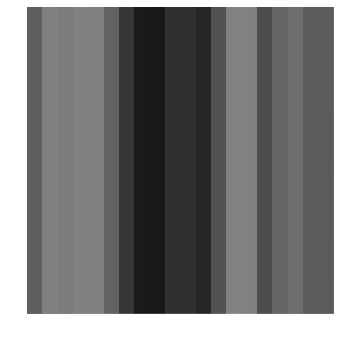

In [140]:
imshow(i_hr_recons3d[:,:,0,0], interpolation='none', cmap='gray')
img_utils._is(i_hr_recons3d)

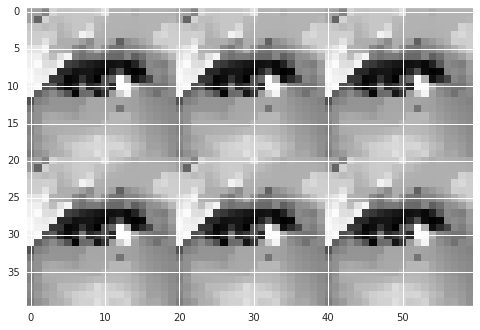

In [137]:
imshow(bimg3d[:40,:60], interpolation='none', cmap='gray')

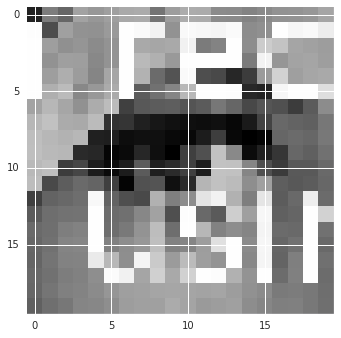

In [138]:
imshow(i_hr[:,:,0,0], interpolation='none', cmap='gray')